In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data     
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
from torch.utils.data import SubsetRandomSampler, DataLoader
from matplotlib.ticker import MaxNLocator

cudnn.benchmark = True
plt.ion()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
data_transforms = {
    'train': transforms.Compose([transforms.RandomResizedCrop(224), transforms.RandomHorizontalFlip(), 
                                 transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([transforms.Resize(256),transforms.CenterCrop(224),
        transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [3]:
data_Directory = "./SAME_dataset"

In [4]:
train_ratio = 0.7
val_ratio = 0.2
train_data = datasets.ImageFolder(root=data_Directory,transform=data_transforms["train"])
val_data = datasets.ImageFolder(root=data_Directory,transform=data_transforms["val"])
indices = list(range(len(train_data)))
np.random.shuffle(indices)
split_train = int(len(train_data)*train_ratio)
split_val = int(len(train_data)*val_ratio)
split_test = int(len(train_data)-split_val-split_train)

train_idx = indices[:split_train]
val_idx = indices[split_train:split_train+split_val]
test_idx = indices[split_train+split_val:]

assert len(train_idx) + len(val_idx) + len(test_idx) == len(train_data), "Indices mismatch!"

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)
test_sampler = SubsetRandomSampler(test_idx)

In [5]:
BATCH_SIZE = 32
dataloaders = {
    "train": DataLoader(train_data, batch_size=BATCH_SIZE, sampler=train_sampler, num_workers=4),
    "test": DataLoader(val_data, batch_size=BATCH_SIZE, sampler=test_sampler, num_workers=4),
    "val": DataLoader(val_data, batch_size=BATCH_SIZE, sampler=val_sampler, num_workers=4)}
dataset_batch_sizes = {x:len(dataloaders[x]) for x in ["train","test","val"]}
dataset_sizes ={"train": len(train_idx), "test": len(test_idx), "val": len(val_idx)}
class_names = train_data.classes

In [6]:
print("Class Names: ", class_names)
print(len(class_names))
print("Dataset Batch Sizes: ",dataset_batch_sizes)
print("Dataset Sizes: ", dataset_sizes)

Class Names:  ['Agriculture', 'Beach', 'City', 'Desert', 'Forest', 'Grassland', 'Highway', 'Lake', 'Mountain', 'Parking', 'Port', 'Residential', 'Water']
13
Dataset Batch Sizes:  {'train': 228, 'test': 33, 'val': 65}
Dataset Sizes:  {'train': 7272, 'test': 1040, 'val': 2078}


In [7]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

Here we can see one example batch prepared by the DataLoaders

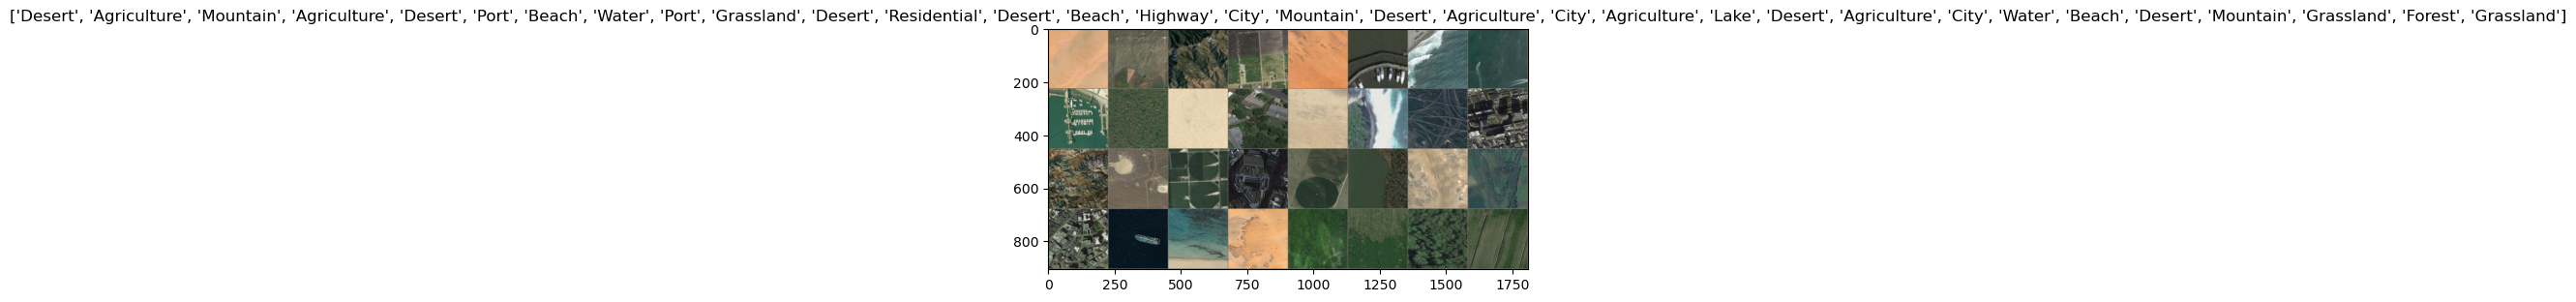

In [8]:
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    train_acc_list, train_loss_list,val_acc_list,val_loss_list = [],[],[],[]
    since = time.time()

    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation part
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize ONLY if in training phase

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                if phase == 'train':
                    train_acc_list.append(epoch_acc)
                    train_loss_list.append(epoch_loss)

                if phase == 'val':
                    val_acc_list.append(epoch_acc)
                    val_loss_list.append(epoch_loss)

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # Copy the best model available to the directory
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
        minutes = time_elapsed // 60
    return model, train_acc_list, train_loss_list, val_acc_list, val_loss_list, best_acc, minutes

In [10]:
def plot_model_performance(model_name,epoch_count,train_acc_list, train_loss_list, val_acc_list, val_loss_list,minutes_taken):
    for i in [train_acc_list,val_acc_list]:
        for j in range(len(i)):
            i[j] = torch.Tensor.cpu(i[j])
    epoch_range = np.arange(1,epoch_count+1,1)    
    fig, axs = plt.subplots(2,1, layout="constrained")
    title_text = f"Results for {model_name}"
    
    axs[0].title.set_text(title_text)
    axs[0].plot(epoch_range,train_acc_list, epoch_range, val_acc_list)
    axs[0].legend(["Train Accuracy","Validation Accuracy"])
    axs[0].axis([0.8,epoch_count+0.3,0.0,1])
    axs[0].grid(True)
    axs[0].xaxis.set_major_locator(MaxNLocator(integer=True))

    axs[1].plot(epoch_range,train_loss_list,epoch_range,val_loss_list)
    axs[1].legend(["Train Loss", "Validation Loss"])
    axs[1].axis([0.8,epoch_count+0.3,0.0,4])
    axs[1].grid(True)
    axs[1].xaxis.set_major_locator(MaxNLocator(integer=True))

    bottom_text = f"Training took: {int(minutes_taken)} minutes"
    axs[1].set_xlabel(bottom_text)
    directory_name = "./modelresults/" + model_name + ".png"
    fig.savefig(directory_name)


In [11]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)
    with torch.no_grad():
        outputs = model(img)
        print(outputs)
        _, preds = torch.max(outputs, 1)
        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)



In [17]:
model_list = ["regnet_y_400mf","regnet_y_16gf","mobilenet_v3_small","resnext101_32x8d","resnext50_32x4d","convnext_base","convnext_small","efficientnet_b0","efficientnet_b1","efficientnet_b2","efficientnet_b3",
              "efficientnet_b4","efficientnet_b5","efficientnet_b6","efficientnet_b7","alexnet","resnet18","resnet34","resnet50","resnet101"]

model_list = ["regnet_y_16gf"]

model_dictionary = {}
epochs = 20

#default = 0.0001
learning_rate = 0.1

#default = 0.9
mmtum = 0.9

#default = 0.1
gmma = 0.1

#default = 7
step_s = 7

Running the Model Evaulation (20 epochs) with the following parameters: 
Learning rate: 0.1 
Momentum: 0.9 
Gamma: 0.1
Step Size: 7
With The specified models: ['regnet_y_16gf']


fc attribute found for:  regnet_y_16gf
Epoch 0/19
----------
train Loss: 3.9558 Acc: 0.7419
val Loss: 2.5156 Acc: 0.8359
Epoch 1/19
----------
train Loss: 2.3022 Acc: 0.8567
val Loss: 1.3926 Acc: 0.8936
Epoch 2/19
----------
train Loss: 2.1100 Acc: 0.8647
val Loss: 0.6034 Acc: 0.9442
Epoch 3/19
----------
train Loss: 1.8129 Acc: 0.8793
val Loss: 1.0188 Acc: 0.9158
Epoch 4/19
----------
train Loss: 1.5875 Acc: 0.8927
val Loss: 1.7350 Acc: 0.9086
Epoch 5/19
----------
train Loss: 1.7851 Acc: 0.8853
val Loss: 1.2635 Acc: 0.9081
Epoch 6/19
----------
train Loss: 1.6376 Acc: 0.8987
val Loss: 1.0928 Acc: 0.9220
Epoch 7/19
----------
train Loss: 0.8618 Acc: 0.9365
val Loss: 0.4922 Acc: 0.9572
Epoch 8/19
----------
train Loss: 0.8179 Acc: 0.9388
val Loss: 0.5110 Acc: 0.9552
Epoch 9/19
----------
train Loss: 0.7461 Acc

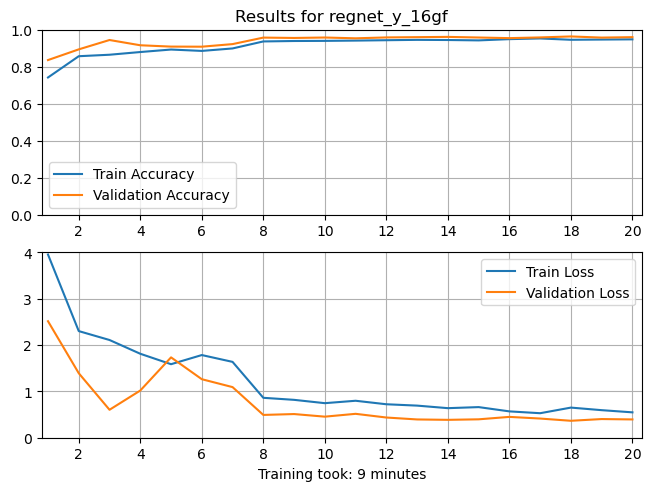

In [18]:
num_of_classes = 13

print(f"Running the Model Evaulation ({epochs} epochs) with the following parameters: \nLearning rate: {learning_rate} \nMomentum: {mmtum} \nGamma: {gmma}\nStep Size: {step_s}\nWith The specified models: {model_list}\n\n")

for current_model in model_list:
    try:
        model_class = getattr(models, current_model)
        model_conv = model_class(weights='IMAGENET1K_V1')

        for param in model_conv.parameters():
            param.requires_grad = False

        if hasattr(model_conv, 'fc'):
            print("fc attribute found for: ", current_model)
            model_conv.fc = nn.Linear(model_conv.fc.in_features, num_of_classes)
            optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=learning_rate, momentum=mmtum)

        elif hasattr(model_conv, 'classifier'):
            # Replace the classifier with a new one
            print("classifier attribute found for: ", current_model)
            model_conv.classifier[-1] = nn.Linear(model_conv.classifier[-1].in_features, num_of_classes)
            optimizer_conv = optim.SGD(model_conv.classifier[-1].parameters(), lr=learning_rate, momentum=mmtum)


        model_conv = model_conv.to(device)

        criterion = nn.CrossEntropyLoss()

        # Decay learning rate by a factor of 0.1 every step_s epochs
        exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=step_s, gamma=gmma)


        model_ft, train_acc, train_loss, val_acc, val_loss, best_accuracy, minutes_elapsed = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler,
                                num_epochs=epochs)
        
        model_dictionary[current_model] = best_accuracy, minutes_elapsed

        plot_model_performance(current_model,epochs,train_acc,train_loss,val_acc,val_loss,minutes_elapsed)
        
    except Exception as e:
        print(f"Error encountered with model {current_model}: {e}")
        continue 

Export to TorchScript and Save the model

In [28]:
model_scripted = torch.jit.script(model_ft) 
model_scripted.save('convnext_v2.pt') # Save